

This notebook contains an example for teaching.


# A Simple Case Study using Wage Data from 2015 - proceeding

So far we considered many machine learning method, e.g Lasso and Random Forests, to build a predictive model. In this lab, we extend our toolbox by predicting wages by a neural network.

## Data preparation

Again, we consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.

In [1]:
# import Pkg; Pkg.add("Flux")

In [2]:
using RData, LinearAlgebra, GLM, DataFrames, Statistics, Random, Distributions, DataStructures, NamedArrays, PrettyTables, Plots
import CodecBzip2

In [3]:
# Importing .Rdata file
rdata_read = load("../data/wage2015_subsample_inference.RData")

Dict{String, Any} with 1 entry:
  "data" => 5150×20 DataFrame…

In [4]:
# Since rdata_read is a dictionary, we check if there is a key called "data", the one we need for our analyze
haskey(rdata_read, "data")

true

In [5]:
# Now we save that dataframe with a new name
data = rdata_read["data"]
names(data)

20-element Vector{String}:
 "wage"
 "lwage"
 "sex"
 "shs"
 "hsg"
 "scl"
 "clg"
 "ad"
 "mw"
 "so"
 "we"
 "ne"
 "exp1"
 "exp2"
 "exp3"
 "exp4"
 "occ"
 "occ2"
 "ind"
 "ind2"

In [11]:
typeof(data), size(data)

(DataFrame, (5150, 20))

In [12]:
Z =  select(data, ["lwage", "wage"])     # regressors

,lwage,wage
,Float64,Float64
1,2.26336,9.61538
2,3.8728,48.0769
3,2.40313,11.0577
4,2.63493,13.9423
5,3.36198,28.8462
6,2.46222,11.7308
7,2.95651,19.2308
8,2.95651,19.2308
9,2.48491,12.0


Firt, we split the data first and normalize it.

In [13]:
Random.seed!(1234) 
training = sample(1:nrow(data), Int(floor(nrow(data)*(3/4))), replace = false)

3862-element Vector{Int64}:
 2455
 3109
 4807
 3107
  617
 2230
 4697
  755
  771
 3729
 2063
  528
 3238
    ⋮
 4057
  973
 4183
 1230
 3228
 3687
 4789
 4060
 2723
 3610
  899
 1273

In [14]:
data_train = data[training,1:16]
data_test = data[Not(training),1:16]
data_train

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,12.0192,2.48651,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,10.2857,2.33076,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,10.5769,2.35867,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,17.3077,2.85115,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,25.641,3.24419,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,42.3077,3.74497,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,15.8654,2.76414,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,72.1154,4.27827,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,35.7143,3.57555,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
size(data_train), size(data_test)

((3862, 16), (1288, 16))

In [16]:
# normalize the data

mean_1 = mean.(eachcol(data_train))
mean_1 = [names(data_train) mean_1]

16×2 Matrix{Any}:
 "wage"   23.3849
 "lwage"   2.97164
 "sex"     0.44407
 "shs"     0.0222683
 "hsg"     0.24754
 "scl"     0.283014
 "clg"     0.310979
 "ad"      0.136199
 "mw"      0.262558
 "so"      0.296737
 "we"      0.215691
 "ne"      0.225013
 "exp1"   13.6699
 "exp2"    2.97307
 "exp3"    8.05316
 "exp4"   24.4216

In [17]:
std_1 = std.(eachcol(data_train))
std_1 = [names(data_train) std_1]

16×2 Matrix{Any}:
 "wage"   20.445
 "lwage"   0.566839
 "sex"     0.496926
 "shs"     0.147574
 "hsg"     0.431639
 "scl"     0.450522
 "clg"     0.462954
 "ad"      0.343044
 "mw"      0.440081
 "so"      0.456879
 "we"      0.411354
 "ne"      0.417645
 "exp1"   10.5105
 "exp2"    3.94797
 "exp3"   14.2448
 "exp4"   52.4952

In [18]:
df = DataFrame()
for i in 1:size(data_train)[2]
     p = (data_train[!, i] .- mean_1[i,2]) / std_1[i,2]
     colname = names(data_train)[i]
     df[!,colname] = p
end
data_train = df
data_train

,wage,lwage,sex,shs,hsg,scl,clg,ad
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.555914,-0.855849,-0.893634,-0.150896,-0.573489,-0.628192,1.48831,-0.39703
2,-0.640703,-1.13062,-0.893634,-0.150896,1.74326,-0.628192,-0.671727,-0.39703
3,-0.62646,-1.08137,-0.893634,-0.150896,-0.573489,1.59146,-0.671727,-0.39703
4,-0.297246,-0.212557,1.11874,-0.150896,-0.573489,1.59146,-0.671727,-0.39703
5,0.110351,0.480836,-0.893634,-0.150896,-0.573489,1.59146,-0.671727,-0.39703
6,0.925545,1.36429,-0.893634,-0.150896,-0.573489,-0.628192,1.48831,-0.39703
7,-0.367792,-0.36606,-0.893634,6.62538,-0.573489,-0.628192,-0.671727,-0.39703
8,2.38349,2.30512,1.11874,-0.150896,-0.573489,-0.628192,1.48831,-0.39703
9,0.603051,1.06541,1.11874,-0.150896,-0.573489,-0.628192,-0.671727,2.51805


In [19]:
df = DataFrame()
for i in 1:size(data_test)[2]
     p = (data_test[!, i] .- mean_1[i,2]) / std_1[i,2]
     colname = names(data_test)[i]
     df[!,colname] = p
end
data_test = df
data_test

,wage,lwage,sex,shs,hsg,scl,clg
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.67349,-1.24951,1.11874,-0.150896,-0.573489,-0.628192,1.48831
2,-0.461853,-0.594011,1.11874,-0.150896,-0.573489,-0.628192,-0.671727
3,-0.555914,-0.855849,1.11874,-0.150896,-0.573489,1.59146,-0.671727
4,-0.498805,-0.692294,-0.893634,-0.150896,1.74326,-0.628192,-0.671727
5,-0.273731,-0.164221,1.11874,-0.150896,-0.573489,-0.628192,-0.671727
6,-0.346322,-0.317912,1.11874,-0.150896,-0.573489,1.59146,-0.671727
7,-0.556854,-0.858674,-0.893634,-0.150896,-0.573489,1.59146,-0.671727
8,-0.181686,0.0131863,-0.893634,-0.150896,-0.573489,-0.628192,1.48831
9,-0.558527,-0.863707,1.11874,-0.150896,1.74326,-0.628192,-0.671727


In [20]:
typeof(data_train), typeof(data_test)

(DataFrame, DataFrame)

Then, we construct the inputs for our network.

In [21]:
formula_basic = @formula(lwage ~ sex + exp1 + shs + hsg+ scl + clg + mw + so + we)
println(formula_basic)

lwage ~ sex + exp1 + shs + hsg + scl + clg + mw + so + we


In [45]:
model_X_basic_train = ModelMatrix(ModelFrame(formula_basic, data_train)).m
model_X_basic_test = ModelMatrix(ModelFrame(formula_basic, data_test)).m

1288×10 Matrix{Float64}:
 1.0   1.11874   -0.634592   -0.150896  …  -0.596613  -0.649488  -0.524344
 1.0   1.11874    1.07799    -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874   -0.777306   -0.150896     -0.596613  -0.649488  -0.524344
 1.0  -0.893634  -0.539448   -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874   -0.254019   -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874    1.03041    -0.150896  …  -0.596613  -0.649488  -0.524344
 1.0  -0.893634  -0.87245    -0.150896     -0.596613  -0.649488  -0.524344
 1.0  -0.893634   1.17313    -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874    0.0314105  -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874    1.64884    -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874   -0.254019   -0.150896  …  -0.596613  -0.649488  -0.524344
 1.0  -0.893634   1.26827    -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874    0.364412   -0.150896     -0.596613  -0.649488  -0.524344


In [46]:
Y_train = data_train[!,"lwage"]
Y_test = data_test[!,"lwage"]

1288-element Vector{Float64}:
 -1.2495116701816313
 -0.5940111369079969
 -0.8558489593188235
 -0.6922940066202594
 -0.16422085652454593
 -0.3179120121732921
 -0.8586738886527183
  0.013186299642166738
 -0.8637071816306149
  0.36697911041067455
  1.3178594848348544
 -1.1634376242266362
 -1.7570311742901377
  ⋮
 -1.2495116701816313
  0.43617103718140365
 -0.07134846692710259
 -0.3847866913343217
 -1.2495116701816313
 -0.8558489593188235
  0.5351222789388115
  0.25782050367552267
 -0.6062199606652643
 -0.4923631674195659
  1.1961444692773646
  0.9241967739720466

In [19]:
# df = DataFrame()
# for i in 1:size(data_train)[2]
#      p = normalize(data_train[!,i])
#      colname = names(data_train)[i]
#      df[!,colname] = p
# end
# df
# # data_test = df
# # data_test


In [20]:
# normalize(data_train[!,])

In [24]:
size(Y_train)

(3862,)

In [25]:
model_X_basic_train

3862×10 Matrix{Float64}:
 1.0  -0.893634   1.07799    -0.150896  …   1.67569   -0.649488  -0.524344
 1.0  -0.893634  -0.444305   -0.150896     -0.596613   1.53928   -0.524344
 1.0  -0.893634   1.12556    -0.150896     -0.596613  -0.649488   1.90665
 1.0   1.11874   -0.920021   -0.150896     -0.596613   1.53928   -0.524344
 1.0  -0.893634   2.17213    -0.150896     -0.596613  -0.649488  -0.524344
 1.0  -0.893634  -0.158876   -0.150896  …   1.67569   -0.649488  -0.524344
 1.0  -0.893634   0.411983    6.62538      -0.596613  -0.649488   1.90665
 1.0   1.11874   -0.444305   -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874   -1.20545    -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874   -0.349162   -0.150896     -0.596613   1.53928   -0.524344
 1.0  -0.893634   0.935271   -0.150896  …   1.67569   -0.649488  -0.524344
 1.0   1.11874    0.507126   -0.150896     -0.596613  -0.649488  -0.524344
 1.0  -0.893634   0.697413   -0.150896     -0.596613   1.53928   -0.524344
 ⋮

### Neural Networks

First, we need to determine the structure of our network. We are using the R package *keras* to build a simple sequential neural network with three dense layers.

In [26]:
size(model_X_basic_train)

(3862, 10)

In [82]:
using Flux
using Flux: crossentropy, @epochs
using Flux.Data: DataLoader
using Flux: throttle
using Flux: onehotbatch, onecold, @epochs

In [83]:
model_nn = Chain(Dense(size(model_X_basic_train,2), 20, relu), 
              Dense(20, size(model_X_basic_train,2), relu),
              Dense(10, 1))

Chain(Dense(10, 20, relu), Dense(20, 10, relu), Dense(10, 1))

In [84]:
# compile the Flux model
model = model_nn
#opt(x, y) = Descent()
opt1 = ADAM()
loss(x, y) = Flux.Losses.mse(model(x), y)
metrics(x, y) = Flux.mae(model(x), y)

metrics (generic function with 1 method)

In [85]:
ps = Flux.params(model)

Params([Float32[-0.1129414 -0.29369408 … 0.3361785 -0.3730879; -0.065885015 0.008057578 … 0.2860582 0.0017144078; … ; 0.3849911 -0.3340452 … 0.17186706 0.15489891; -0.27252343 -0.23161511 … 0.04841264 -0.323494], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.15441547 0.122873 … -0.2977946 0.09255712; 0.2533373 -0.25251332 … -0.29327345 0.06759121; … ; 0.43840528 0.38483554 … 0.18124762 -0.3953458; 0.42269453 0.3865057 … -0.15502952 0.3532663], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.31053326 0.18248866 … -0.31109056 -0.29544342], Float32[0.0]])

Let us have a look at the structure of our network in detail.

In [86]:
model

Chain(Dense(10, 20, relu), Dense(20, 10, relu), Dense(10, 1))

It is worth to notice that we have in total $441$ trainable parameters.

Now, let us train the network. Note that this takes some computation time. Thus, we are using gpu to speed up. The exact speed-up varies based on a number of factors including model architecture, batch-size, input pipeline complexity, etc.

In [44]:
# m1 = zeros(size(model_X_basic_train, 1), size(model_X_basic_train, 2) - 1 )
# Y_train = hcat(Y_train, m1)

In [87]:
loss(model_X_basic_train', Y_train')

1.5247699038109273

In [90]:
opt(model_X_basic_train', Y_train)

Descent(0.1)

In [91]:
data = DataLoader((model_X_basic_train', Y_train'))

DataLoader{Tuple{Adjoint{Float64, Matrix{Float64}}, Adjoint{Float64, Vector{Float64}}}, Random._GLOBAL_RNG}(([1.0 1.0 … 1.0 1.0; -0.8936342512056518 -0.8936342512056518 … 1.1187362899933146 1.1187362899933146; … ; -0.6494880907521049 1.5392754402117947 … -0.6494880907521049 -0.6494880907521049; -0.5243443952053061 -0.5243443952053061 … -0.5243443952053061 -0.5243443952053061], [-0.8558489593188235 -1.1306215839580365 … -0.026683600452133343 -2.0881111049638306]), 1, 3862, true, 3862, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862], false, Random._GLOBAL_RNG())

In [92]:
# training the network 

#@epochs 1000 Flux.train!(loss, ps, data, opt, cb = throttle(() -> println("training"), 10))
@epochs 1000 Flux.train!(loss, ps, data, opt1, cb = throttle(() -> println("training"), 10))

┌ Info: Epoch 1
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training
training


┌ Info: Epoch 2
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 3
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 4
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 5
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 6
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 7
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 8
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 9
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 10
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 11
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 12
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 13
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 14
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 15
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 16
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 17
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 18
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 19
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 20
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 21
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 22
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 23
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 24
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 25
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 26
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 27
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 28
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 29
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 30
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 31
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 32
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 33
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 34
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 35
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 36
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 37
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 38
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 39
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 40
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 41
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 42
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 43
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 44
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 45
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 46
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 47
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 48
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 49
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 50
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 51
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 52
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 53
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 54
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 55
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 56
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 57
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 58
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 59
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 60
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 61
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 62
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 63
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 64
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 65
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 66
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 67
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 68
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 69
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 70
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 71
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 72
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 73
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 74
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 75
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 76
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 77
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 78
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 79
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 80
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 81
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 82
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 83
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 84
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 85
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 86
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 87
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 88
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 89
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 90
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 91
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 92
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 93
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 94
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 95
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 96
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 97
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 98
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 99
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 100
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 101
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 102
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 103
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 104
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 105
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 106
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 107
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 108
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 109
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 110
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 111
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 112
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 113
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 114
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 115
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 116
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 117
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 118
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 119
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 120
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 121
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 122
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 123
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 124
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 125
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 126
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 127
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 128
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 129
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 130
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 131
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 132
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 133
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 134
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 135
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 136
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 137
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 138
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 139
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 140
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 141
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 142
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 143
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 144
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 145
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 146
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 147
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 148
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 149
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 150
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 151
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 152
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 153
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 154
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 155
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 156
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 157
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 158
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 159
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 160
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 161
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 162
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 163
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 164
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 165
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 166
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 167
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 168
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 169
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 170
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 171
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 172
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 173
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 174
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 175
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 176
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 177
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 178
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 179
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 180
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 181
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 182
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 183
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 184
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 185
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 186
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 187
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 188
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 189
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 190
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 191
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 192
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 193
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 194
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 195
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 196
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 197
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 198
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 199
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 200
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 201
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 202
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 203
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 204
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 205
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 206
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 207
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 208
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 209
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 210
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 211
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 212
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 213
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 214
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 215
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 216
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 217
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 218
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 219
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 220
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 221
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 222
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 223
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 224
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 225
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 226
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 227
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 228
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 229
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 230
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 231
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 232
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 233
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 234
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 235
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 236
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 237
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 238
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 239
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 240
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 241
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 242
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 243
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 244
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 245
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 246
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 247
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 248
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 249
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 250
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 251
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 252
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 253
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 254
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 255
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 256
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 257
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 258
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 259
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 260
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 261
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 262
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 263
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 264
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 265
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 266
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 267
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 268
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 269
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 270
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 271
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 272
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 273
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 274
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 275
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 276
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 277
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 278
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 279
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 280
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 281
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 282
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 283
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 284
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 285
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 286
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 287
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 288
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 289
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 290
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 291
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 292
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 293
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 294
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 295
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 296
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 297
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 298
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 299
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 300
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 301
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 302
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 303
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 304
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 305
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 306
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 307
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 308
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 309
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 310
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 311
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 312
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 313
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 314
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 315
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 316
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 317
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 318
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 319
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 320
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 321
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 322
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 323
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 324
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 325
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 326
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 327
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 328
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 329
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 330
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 331
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 332
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 333
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 334
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 335
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 336
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 337
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 338
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 339
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 340
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 341
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 342
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 343
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 344
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 345
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 346
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 347
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 348
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 349
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training

┌ Info: Epoch 350
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135



training


┌ Info: Epoch 351
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 352
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 353
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 354
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 355
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 356
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 357
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 358
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 359
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 360
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 361
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 362
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 363
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 364
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 365
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 366
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 367
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 368
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 369
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 370
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 371
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 372
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 373
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 374
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 375
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 376
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 377
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 378
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 379
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 380
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 381
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 382
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 383
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 384
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 385
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 386
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 387
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 388
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 389
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 390
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 391
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 392
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 393
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 394
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 395
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 396
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 397
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 398
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 399
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 400
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 401
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 402
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 403
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 404
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 405
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 406
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 407
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 408
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 409
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 410
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 411
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 412
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 413
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 414
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 415
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 416
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 417
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 418
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 419
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 420
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 421
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 422
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 423
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 424
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 425
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 426
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 427
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 428
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 429
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 430
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 431
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 432
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 433
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 434
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 435
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 436
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 437
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 438
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 439
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 440
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 441
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 442
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 443
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 444
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 445
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 446
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 447
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 448
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 449
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 450
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 451
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 452
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 453
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 454
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 455
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 456
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 457
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 458
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 459
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 460
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 461
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 462
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 463
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 464
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 465
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 466
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 467
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 468
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 469
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 470
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 471
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 472
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 473
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 474
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 475
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 476
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 477
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 478
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 479
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 480
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 481
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 482
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 483
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 484
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 485
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 486
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 487
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 488
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 489
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 490
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 491
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 492
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 493
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 494
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 495
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 496
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 497
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 498
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 499
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 500
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 501
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 502
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 503
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 504
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 505
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 506
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 507
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 508
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 509
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 510
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 511
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 512
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 513
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 514
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 515
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 516
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 517
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 518
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 519
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 520
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 521
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 522
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 523
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 524
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 525
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 526
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 527
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 528
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 529
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 530
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 531
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 532
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 533
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 534
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 535
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 536
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 537
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 538
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 539
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 540
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 541
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 542
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 543
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 544
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 545
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 546
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 547
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 548
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 549
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 550
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 551
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 552
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 553
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 554
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 555
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 556
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 557
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 558
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 559
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 560
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 561
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 562
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 563
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 564
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 565
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 566
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 567
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 568
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 569
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 570
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 571
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 572
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 573
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 574
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 575
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 576
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 577
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 578
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 579
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 580
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 581
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 582
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 583
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 584
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 585
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 586
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 587
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 588
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 589
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 590
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 591
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 592
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 593
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 594
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 595
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 596
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 597
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 598
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 599
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 600
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 601
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 602
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 603
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 604
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 605
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 606
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 607
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 608
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 609
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 610
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 611
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 612
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 613
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 614
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 615
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 616
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 617
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 618
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 619
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 620
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 621
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 622
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 623
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 624
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 625
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 626
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 627
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 628
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 629
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 630
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 631
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 632
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 633
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 634
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 635
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 636
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 637
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 638
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 639
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 640
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 641
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 642
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 643
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 644
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 645
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 646
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 647
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 648
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 649
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 650
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 651
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 652
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 653
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 654
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 655
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 656
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 657
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 658
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 659
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 660
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 661
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 662
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 663
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 664
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 665
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 666
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 667
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 668
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 669
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 670
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 671
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 672
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 673
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 674
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 675
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 676
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 677
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 678
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 679
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 680
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 681
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 682
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 683
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 684
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 685
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 686
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 687
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 688
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 689
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 690
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 691
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 692
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 693
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 694
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 695
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 696
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 697
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 698
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 699
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 700
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 701
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 702
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 703
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 704
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 705
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 706
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 707
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 708
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 709
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 710
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 711
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 712
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 713
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 714
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 715
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 716
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 717
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 718
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 719
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 720
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 721
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 722
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 723
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 724
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 725
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 726
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 727
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 728
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 729
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 730
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 731
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 732
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 733
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 734
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 735
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 736
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 737
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 738
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 739
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 740
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 741
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 742
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 743
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 744
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 745
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 746
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 747
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 748
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 749
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 750
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 751
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 752
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 753
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 754
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 755
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 756
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 757
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 758
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 759
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 760
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 761
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 762
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 763
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 764
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 765
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 766
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 767
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 768
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 769
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 770
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 771
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 772
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 773
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 774
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 775
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 776
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 777
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 778
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 779
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 780
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 781
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 782
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 783
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 784
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 785
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 786
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 787
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 788
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 789
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 790
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 791
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 792
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 793
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 794
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 795
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 796
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 797
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 798
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 799
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 800
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 801
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 802
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 803
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 804
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 805
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 806
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 807
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 808
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 809
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 810
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 811
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 812
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 813
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 814
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 815
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 816
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 817
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 818
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 819
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 820
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 821
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 822
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 823
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 824
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 825
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 826
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 827
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 828
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 829
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 830
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 831
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 832
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 833
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 834
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 835
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 836
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 837
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 838
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 839
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 840
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 841
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 842
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 843
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 844
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 845
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 846
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 847
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 848
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 849
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 850
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 851
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 852
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 853
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 854
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 855
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 856
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 857
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 858
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 859
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 860
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 861
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 862
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 863
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 864
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 865
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 866
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 867
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 868
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 869
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 870
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 871
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 872
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 873
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 874
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 875
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 876
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 877
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 878
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 879
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 880
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 881
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 882
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 883
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 884
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 885
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 886
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 887
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 888
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 889
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 890
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 891
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 892
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 893
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 894
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 895
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 896
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 897
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 898
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 899
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 900
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 901
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 902
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 903
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 904
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 905
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 906
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 907
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 908
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 909
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 910
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 911
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 912
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 913
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 914
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 915
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 916
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 917
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 918
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 919
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 920
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 921
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 922
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 923
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 924
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 925
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 926
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 927
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 928
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 929
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 930
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 931
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 932
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 933
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 934
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 935
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 936
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 937
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 938
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 939
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 940
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 941
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 942
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 943
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 944
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 945
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 946
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 947
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 948
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 949
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 950
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 951
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 952
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 953
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 954
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 955
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 956
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 957
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 958
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 959
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 960
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 961
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training

┌ Info: Epoch 962
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135



training


┌ Info: Epoch 963
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 964
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 965
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 966
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 967
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 968
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 969
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 970
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 971
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 972
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 973
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 974
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 975
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 976
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 977
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 978
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 979
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 980
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 981
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 982
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 983
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 984
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 985
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 986
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 987
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 988
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 989
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 990
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 991
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 992
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 993
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 994
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 995
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 996
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 997
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 998
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 999
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


training


┌ Info: Epoch 1000
└ @ Main C:\Users\PC\.julia\packages\Flux\qp1gc\src\optimise\train.jl:135


After training the neural network, we can evaluate the performance of our model on the test sample.

In [ ]:
# # evaluating the performnace
# model %>% evaluate(model_X_basic_test, Y_test, verbose = 0)

In [93]:
# Calculating the performance measures 

pred_nn = model(model_X_basic_test')'
# We change the type of this variable in order to make numeric operations
pred_nn = vec(pred_nn)

resid_basic = (Y_test .- pred_nn).^2

one = vec(ones(size(Y_test,1),1))

resid_basic = DataFrame([resid_basic], [:resid_basic])

one = DataFrame([one], [:one])
data_aux = [resid_basic one]

fm = @formula(resid_basic ~ 0 + one)

MSE_nn_basic = lm(fm, data_aux, dropcollinear=false)

@show coef(MSE_nn_basic)
@show stderror(MSE_nn_basic)

R2_nn_basic = 1 .- (coef(MSE_nn_basic) / var(Y_test))
println("The R^2 using NN is equal to ", R2_nn_basic) # MSE NN (basic model) 

coef(MSE_nn_basic) = [0.9299250584273192]
stderror(MSE_nn_basic) = [0.052566401001302235]
The R^2 using NN is equal to [0.11516006433982762]


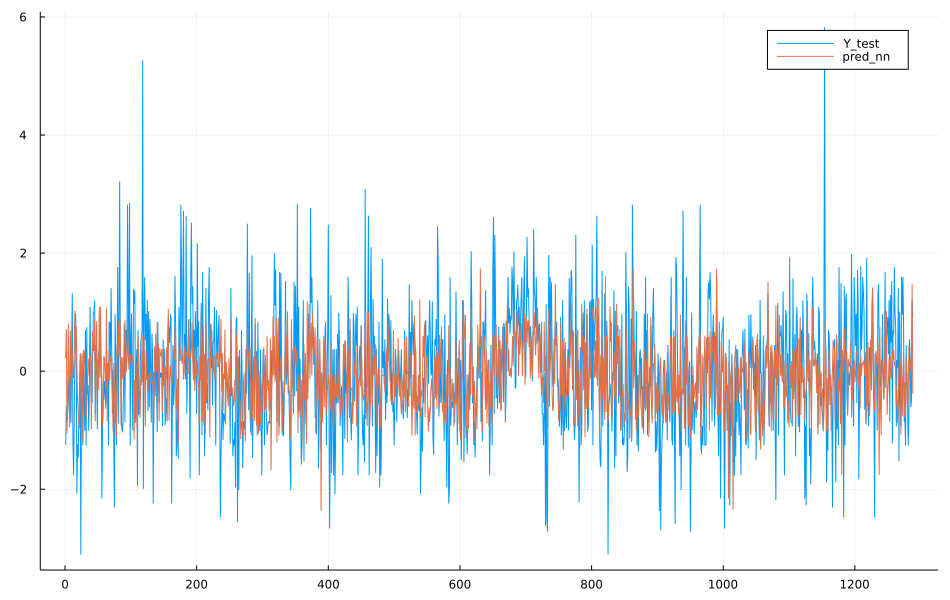

In [94]:
plot(Y_test, label = "Y_test")
plot!(pred_nn, label = "pred_nn")
plot!(size=(950,600))